In [1]:
import pandas as pd
pd.set_option('display.max_columns', 250)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

SEED = 43

# model training
from sklearn import linear_model
# Check https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
from sklearn.linear_model import SGDClassifier # Log losss for logistic regressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import OneClassSVM

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import precision_recall_fscore_support
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import matthews_corrcoef, make_scorer
! pip -q install optuna
import optuna

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn import tree

import xgboost as xgb
import multiprocessing

# !pip install pytorch-tabnet
# import pytorch_tabnet
# from pytorch_tabnet.tab_model import TabNetClassifier
# import torch

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers

!pip install shap

import shap

# !pip install dython
# import dython
# from dython.nominal import associations
import missingno as msno

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def train_model(X_train, X_val, y_train, y_val, grid_search=False,trials=10,view_trees=False,model='baseline'):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val
    if grid_search:
      print("user chose to do gridsearch")
      def create_model(trial):

        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }

        model = RandomForestClassifier(random_state=SEED, **params)

        return model

      def objective(trial:optuna.trial.Trial):
          params = {
              'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
              'max_depth': trial.suggest_int('max_depth', 4, 50),
              'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
          }

          model = create_model(trial)
          model.fit(normalized_train_X, y_train)
          y_pred = model.predict(X_val)
          score = balanced_accuracy_score(y_val, y_pred)
          return score


      study_rf = optuna.create_study(direction='maximize')
      study_rf.optimize(objective, n_trials=trials)

      fig = optuna.visualization.plot_optimization_history(study_rf)
      fig.show()

      # criação do modelo que performou melhor
      print("creating best model predictions")
      model = create_model(study_rf.best_trial)
      display(model)
      display(model.get_params())

      model.fit(normalized_train_X ,y_train)
      y_pred = model.predict(X_val)

    else:
      print("running models with no gridsearch")
      if model =='baseline':
        # baseline
        model = RandomForestClassifier(random_state=SEED,n_estimators= 500, max_depth=30, min_samples_leaf=5, n_jobs=-1)
      elif model =='tuned':
        # tunado sem SMOTE
        model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
      elif model =='tunedsmote':
        # tunado com SMOTE
        model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
                        n_estimators=160, random_state=SEED)
      elif model =='tunedadasys':
        params = {'bootstrap': True,
                  'ccp_alpha': 0.0,
                  'criterion': 'gini',
                  'max_depth': 8,
                  'max_features': 'sqrt',
                  'min_impurity_decrease': 0.0,
                  'min_samples_leaf': 1,
                  'min_samples_split': 146,
                  'min_weight_fraction_leaf': 0.0,
                  'n_estimators': 272,
                  'oob_score': False,
                  'verbose': 0,
                  'warm_start': False}
        model = RandomForestClassifier(random_state=SEED, **params)
      elif model == 'xgboost':
        xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
        model = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                      'n_estimators': [50, 100, 200]}, verbose=1,
                          n_jobs=2)
      else:
        print("specify model params")

      model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    try:
      y_pred_proba = model.predict_proba(X_val)[:, 1]
    except:

      y_pred_proba = y_pred
    return model, X_val,y_pred, y_val,y_pred_proba

def print_classification_report(y_val, y_val_pred,y_val_pred_proba=None,auc_metrics=False):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)


    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()
    total1=sum(sum(matriz_confusão))
    #####from confusion matrix calculate accuracy
    # accuracy1=(matriz_confusão[0,0]+matriz_confusão[1,1])/total1
    # print ('Accuracy : ', accuracy1)
    sensitivity1 = matriz_confusão[0,0]/(matriz_confusão[0,0]+matriz_confusão[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = matriz_confusão[1,1]/(matriz_confusão[1,0]+matriz_confusão[1,1])
    print('Specificity : ', specificity1)
    if auc_metrics == True:
      # Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
      fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
      # Calculate AUC score
      auc = roc_auc_score(y_val, y_val_pred_proba)
      print(f'AUC = {auc} ')
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
      plt.plot([0, 1], [0, 1], 'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      plt.close()
from sklearn.metrics import f1_score

def print_classification_report_refact(y_val, y_val_pred,y_val_pred_proba=None,auc_metrics=True,verbose=False):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    macro_f1_score = f1_score(y_val, y_val_pred, average='macro')
    print("Macro f1 score: {:.2f}%".format(macro_f1_score * 100))
    if verbose == True:
        # Gerando o relatório com diversas métricas
        report = classification_report(y_val, y_val_pred)

        # Exibindo o relatório
        print(report)


        # Plotando a matriz de confusão
        matriz_confusão = confusion_matrix(y_val, y_val_pred)
        sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()
        plt.close()
        total1=sum(sum(matriz_confusão))
        #####from confusion matrix calculate accuracy
        # accuracy1=(matriz_confusão[0,0]+matriz_confusão[1,1])/total1
        # print ('Accuracy : ', accuracy1)
        sensitivity1 = matriz_confusão[0,0]/(matriz_confusão[0,0]+matriz_confusão[0,1])
        print('Sensitivity : ', sensitivity1 )

        specificity1 = matriz_confusão[1,1]/(matriz_confusão[1,0]+matriz_confusão[1,1])
        print('Specificity : ', specificity1)
        if auc_metrics == True:
          # Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
          fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
          # Calculate AUC score
          auc = roc_auc_score(y_val, y_val_pred_proba)
          print(f'AUC = {auc} ')
          # Plot ROC curve
          plt.figure(figsize=(8, 6))
          plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
          plt.plot([0, 1], [0, 1], 'r--')
          plt.xlim([0, 1])
          plt.ylim([0, 1])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic (ROC) Curve')
          plt.legend(loc='lower right')
          plt.show()
          plt.close()
    return y_val, y_val_pred,macro_f1_score

def train_model_nn(X_train, X_val, y_train, y_val, grid_search=False,trials=5,view_trees=False,model='baseline'):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val
    if grid_search:
      print("user chose to do gridsearch")

      def create_model(trial):
        n_layers = trial.suggest_int('n_layers', 1, 10)
        layers = []
        for i in range(n_layers):
            layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))

        model = MLPClassifier(solver='adam', alpha= trial.suggest_float("alpha", 1e-5,0.1, log=True),
                                    hidden_layer_sizes=tuple(layers),
                                    random_state=SEED, max_iter=10000)

        return model


      def objective(trial):
          params = {
              'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
              'max_depth': trial.suggest_int('max_depth', 4, 50),
              'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
          }

          model = create_model(trial)
          model.fit(normalized_train_X, y_train)
          y_pred = model.predict(X_val)
          score = balanced_accuracy_score(y_val, y_pred)
          return score


      study_rf = optuna.create_study(direction='maximize')
      study_rf.optimize(objective, n_trials=trials)

      fig = optuna.visualization.plot_optimization_history(study_rf)
      fig.show()

      # criação do modelo que performou melhor
      print("creating best model predictions")
      model = create_model(study_rf.best_trial)
      display(model)
      display(model.get_params())

      model.fit(normalized_train_X ,y_train)
      y_pred = model.predict(X_val)

    else:
      print("running models with no gridsearch")
      # if model =='baseline':
      #   # baseline
      #   model = RandomForestClassifier(random_state=SEED,n_estimators= 500, max_depth=30, min_samples_leaf=5, n_jobs=-1)
      # elif model =='tuned':
      #   # tunado sem SMOTE
      #   model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
      # elif model =='tunedsmote':
      #   # tunado com SMOTE
      #   model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
      #                   n_estimators=160, random_state=SEED)
      # elif model =='tunedadasys':
      #   params = {'bootstrap': True,
      #             'ccp_alpha': 0.0,
      #             'criterion': 'gini',
      #             'max_depth': 8,
      #             'max_features': 'sqrt',
      #             'min_impurity_decrease': 0.0,
      #             'min_samples_leaf': 1,
      #             'min_samples_split': 146,
      #             'min_weight_fraction_leaf': 0.0,
      #             'n_estimators': 272,
      #             'oob_score': False,
      #             'verbose': 0,
      #             'warm_start': False}
      #   model = RandomForestClassifier(random_state=SEED, **params)
      # else:
      #   print("specify model params")

      model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    return model, X_val,y_pred, y_val,y_pred_proba



def train_model_nntorch(X_train, X_val, y_train, y_val, grid_search=False,trials=10,view_trees=False,model='baseline'):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val
    # define the model
    model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=2e-2),
                          scheduler_params={"step_size":10, # how to use learning rate scheduler
                                            "gamma":0.9},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,
                          mask_type='entmax' # "sparsemax"
                          )

    # fit the model
    model.fit(
        X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=1000 , patience=50,
        batch_size=256, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )

    # criação do modelo que performou melhor
    print("creating best model predictions")
    display(model)
    # display(model.get_params())

    # plot losses
    plt.plot(model.history['loss'])

    # plot accuracy
    plt.plot(model.history['train_accuracy'])
    plt.plot(model.history['valid_accuracy'])

    # find and plot feature importance
    y_pred = model.predict(X_val)
    model.feature_importances_
    feat_importances = pd.Series(model.feature_importances_)
    feat_importances.nlargest(20).plot(kind='barh')


    # # determine best accuracy for test set
    # preds = model.predict(x_test)
    # test_acc = accuracy_score(preds, y_test)

    # determine best accuracy for validation set
    preds_valid = model.predict(X_val)
    valid_acc = accuracy_score(preds_valid, y_val)

    # y_pred_proba = model.predict_proba(X_val)[:, 1]

    return model, X_val,y_pred, y_val#,y_pred_proba

In [3]:

df = pd.read_csv('/kaggle/input/state-of-data-2022/State_of_data_2022.csv', low_memory=False)

Primeiramente, vamos filtrar o conjunto de dados para incluir somente os respondentes que trabalham na área de dados e forneceram informações sobre o salário. Isso nos permitirá focar naqueles que são relevantes para nossa análise.Nesta fase da análise, concentraremos nossa atenção nas Partes 1 e 2 do questionário, que tratam de dados demográficos e informações sobre a carreira dos profissionais atuantes na área de dados no mercado brasileiro. Nosso objetivo é entender como essas variáveis podem estar relacionadas com a faixa salarial.

A análise de correlação nos ajudará a identificar quais variáveis têm uma relação forte com a variável alvo, que é a faixa salarial.  As correlações podem variar de -1 a 1, onde valores próximos de 1 indicam uma correlação positiva forte, valores próximos de -1 indicam uma correlação negativa forte, e valores próximos de 0 indicam pouca ou nenhuma correlação.

In [4]:
# Função para filtrar as colunas
def filter_columns(df, substrings):
    return df.filter(items=[col for col in df.columns if any(sub in col for sub in substrings)])


# Filtrar apenas as colunas com 'p1' ou 'p2' nos títulos
df_filtered = filter_columns(df, substrings=['P0','P1', 'P2'])

# df_filtered

In [5]:
# Função para extrair o nome da coluna dos títulos
def extract_column_name(title):
    return title.split(", ")[1][1:-2]

# Renomear as colunas
df_filtered.columns = [extract_column_name(title) for title in df_filtered.columns]

df_filtered

,id,Idade,Faixa idade,Genero,Cor/raca/etnia,PCD,experiencia_profissional_prejudicada,aspectos_prejudicados,vive_no_brasil,Estado onde mora,uf onde mora,Regiao onde mora,Mudou de Estado?,Regiao de origem,Nivel de Ensino,Área de Formação,Qual sua situação atual de trabalho?,Setor,Numero de Funcionarios,Gestor?,Cargo como Gestor,Cargo Atual,Nivel,Faixa salarial,Quanto tempo de experiência na área de dados você tem?,Quanto tempo de experiência na área de TI/Engenharia de Software você teve antes de começar a trabalhar na área de dados?,Você está satisfeito na sua empresa atual?,Qual o principal motivo da sua insatisfação com a empresa atual?,Falta de oportunidade de crescimento no emprego atual,Salário atual não corresponde ao mercado,Não tenho uma boa relação com meu líder/gestor,Gostaria de trabalhar em em outra área de atuação,Gostaria de receber mais benefícios,O clima de trabalho/ambiente não é bom,Falta de maturidade analítica na empresa,Você participou de entrevistas de emprego nos últimos 6 meses?,Você pretende mudar de emprego nos próximos 6 meses?,Quais os principais critérios que você leva em consideração no momento de decidir onde trabalhar?,Remuneração/Salário,Benefícios,Propósito do trabalho e da empresa,Flexibilidade de trabalho remoto,Ambiente e clima de trabalho,Oportunidade de aprendizado e trabalhar com referências na área,Plano de carreira e oportunidades de crescimento profissional,Maturidade da empresa em termos de tecnologia e dados,Qualidade dos gestores e líderes,Reputação que a empresa tem no mercado,Atualmente qual a sua forma de trabalho?,Qual a forma de trabalho ideal para você?,Caso sua empresa decida pelo modelo 100% presencial qual será sua atitude?,Sua empresa passu por Layoff em 2022?
0,zzqzz3l9ily8nuo2m7wyzzqzz3w48o96,39.0,35-39,Masculino,Parda,Não,Não acredito que minha experiência profissiona...,NaN,True,Distrito Federal (DF),DF,Centro-oeste,False,Sudeste,Pós-graduação,Computação / Engenharia de Software / Sistemas...,Servidor Público,Setor Público,Acima de 3.000,False,NaN,DBA/Administrador de Banco de Dados,Júnior,de R$ 8.001/mês a R$ 12.000/mês,de 1 a 2 anos,de 7 a 10 anos,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não participei de entrevistas de emprego/proce...,Não estou buscando e não pretendo mudar de emp...,Benefícios,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Modelo 100% presencial,Modelo híbrido com dias fixos de trabalho pres...,Vou aceitar e retornar ao modelo 100% presencial,Não ocorreram layoffs/demissões em massa na em...
1,zzls2oftfn9law393oezzls2ofhvfpzd,32.0,30-34,Masculino,Parda,Não,"Sim, acredito que a minha a experiência profis...",Aprovação em processos seletivos/entrevistas,True,Pará (PA),PA,Norte,True,NaN,Graduação/Bacharelado,Outras Engenharias,Empregado (CLT),Outra Opção,Acima de 3.000,True,Supervisor/Coordenador,NaN,NaN,de R$ 4.001/mês a R$ 6.000/mês,de 3 a 4 anos,Menos de 1 ano,False,Falta de oportunidade de crescimento no empreg...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"Sim, fiz entrevistas mas não fui aprovado",Estou em busca de oportunidades dentro ou fora...,"Remuneração/Salário, Plano de carreira e oport...",1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Modelo 100% presencial,Modelo híbrido flexível (o funcionário tem lib...,Vou aceitar e retornar ao modelo 100% presencial,Não ocorreram layoffs/demissões em massa na em...
2,zzdwqzfqqp1ypc7ps6m0hzzdwqz292yi,53.0,50-54,Masculino,Branca,Não,NaN,NaN,True,Distrito Federal (DF),DF,Centro-oeste,False,Sul,Pós-graduação,Computação / Engenharia de Software / Sistemas...,Empregado (CLT),Finanças ou Bancos,Acima de 3.000,False,NaN,Desenvolvedor/ Engenheiro de Software/ Analist...,Pleno,de R$ 12.001/mês a R$ 16.000/mês,de 3 a 4 anos,Mais de 10 anos,False,Falta de oportunidade de crescimento no empreg...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Não participei de entrevistas de emprego/proce...,"Não estou buscando, mas me considero aberto a ...","Remuneração/Salário, Flexibilidade de trabalho...",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Modelo híbrido com dias fixo

## Dados Faltantes e Processamentos

In [6]:
df_essential = df_filtered.iloc[:, :25]

Observamos uma visualização dos dados faltantes no conjunto por colunas, o que é o primeiro passo para o tratamento adequado.

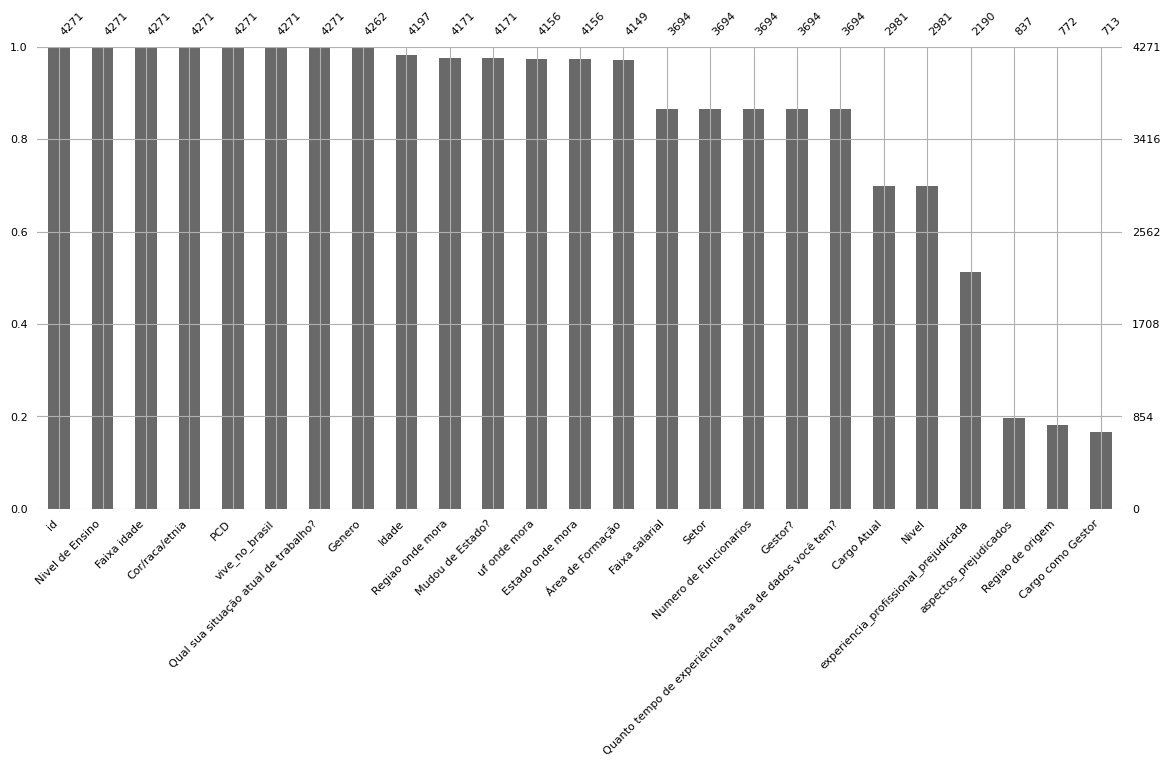

In [7]:


msno.bar(df_essential, sort="descending", figsize=(14,6), fontsize=8).grid()

In [8]:
colunas_a_dropar = ['Estado onde mora', 'experiencia_profissional_prejudicada','aspectos_prejudicados','Cargo como Gestor','Regiao de origem','Idade','vive_no_brasil']  # Adicione aqui os nomes das colunas que deseja dropar
# vive no brasil retirado ja que estado é levado em consideração, idade ja q tem faixa etaria, outras por ter muito na ou ser rdundante como estado e uf
# Dropar as colunas
df_essential = df_essential.drop(columns=colunas_a_dropar)

Para utilizar somente uma variável de Cargo Atual, no caso da pessoa ser gestora, foi criada uma nova categoria e conseguindo evitar a retirada de valores não preenchidos.

In [9]:
df_essential['Gestor?'].fillna(False, inplace=True)
# df_essential['Gestor?'].fillna(False, inplace=True)
df_essential.loc[df_essential['Gestor?'], ['Cargo Atual', 'Nivel']] = 'gestor'

In [10]:
df_essential = df_essential.dropna()


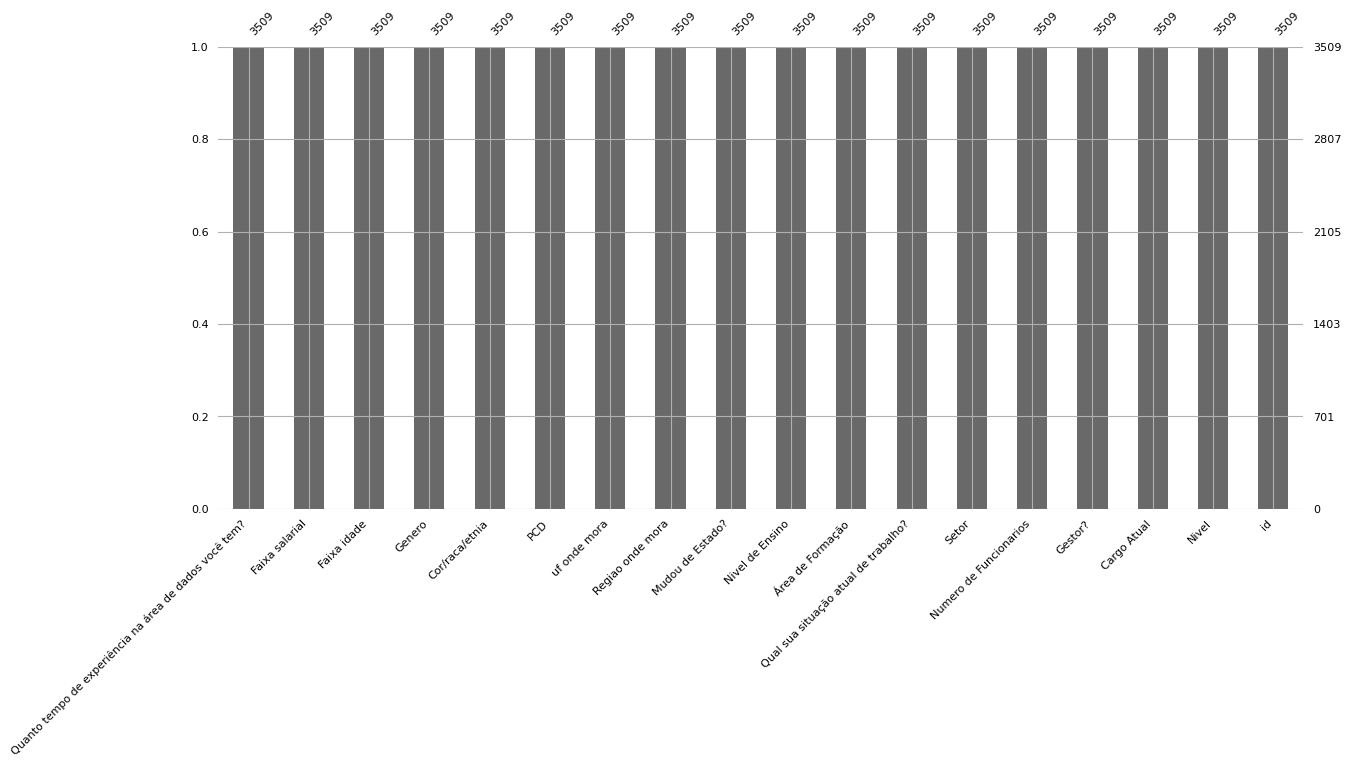

In [11]:
msno.bar(df_essential, sort="descending", figsize=(14,6), fontsize=8).grid()

A partir da visualização percebe-se uma integridade da base, com todos os valores preenchidos e permitindo a análise de correlação.

<a id="section-two"></a>
# <p style="text-align:center; font-size:24px; font-weight:bold;">Análise Exploratória </p>

<a id="subsection-two"></a>
## Visualizações
Vamos analisar as variáveis que podem ter impacto na faixa salarial

In [12]:
custom_order = [
    "Menos de R$ 1.000/mês",
    "de R$ 1.001/mês a R$ 2.000/mês",
    "de R$ 2.001/mês a R$ 3.000/mês",
    "de R$ 3.001/mês a R$ 4.000/mês",
    "de R$ 4.001/mês a R$ 6.000/mês",
    "de R$ 6.001/mês a R$ 8.000/mês",
    "de R$ 8.001/mês a R$ 12.000/mês",
    "de R$ 12.001/mês a R$ 16.000/mês",
    "de R$ 16.001/mês a R$ 20.000/mês",
    "de R$ 20.001/mês a R$ 25.000/mês",
    "de R$ 25.001/mês a R$ 30.000/mês",
    "de R$ 30.001/mês a R$ 40.000/mês",
    "Acima de R$ 40.001/mês"
]

xtick_rotation = 90  # Rotação dos rótulos no eixo x


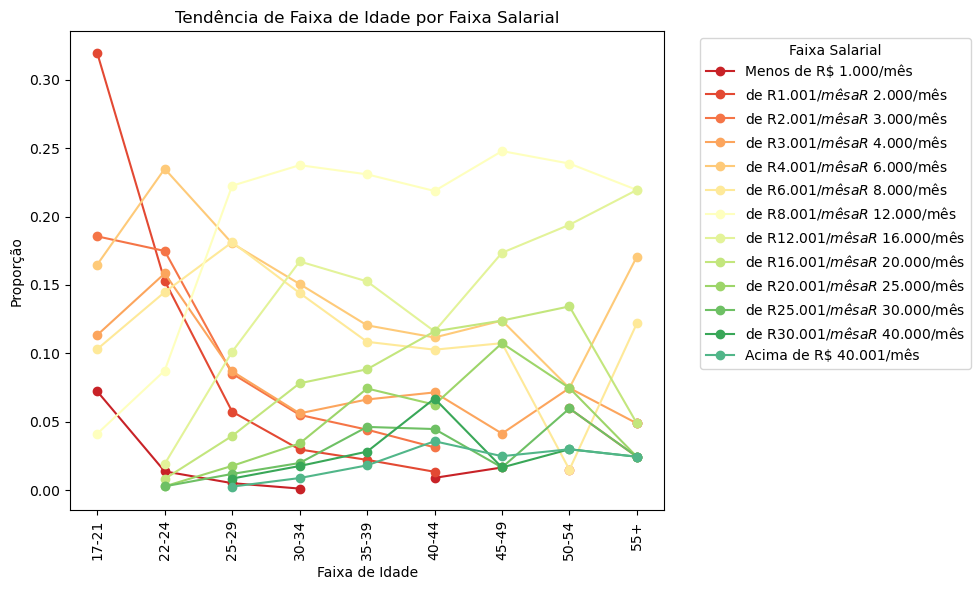

In [13]:
# Definindo uma paleta de cores verde
# colors = sns.color_palette("RdYlGn", n_colors=12)
# plt.figure(figsize=(10, 6))
colors = sns.color_palette("RdYlGn", n_colors=len(custom_order))  # Paleta de cores YlGn
colors[-1] = sns.color_palette("BuGn")[3]  # Substituir o último valor por um tom de verde
sns.set_palette(colors)
# Normalizar as contagens dividindo pela contagem total daquela faixa salarial
normalized_counts_age = df_essential.groupby('Faixa idade')['Faixa salarial'].value_counts(normalize=True).unstack()

# Reordenar as faixas salariais de acordo com a lista personalizada
normalized_counts_age = normalized_counts_age.reindex(custom_order, axis=1)
normalized_counts_age.plot(kind='line', marker='o', figsize=(10, 6), color=colors)
plt.xticks(rotation=xtick_rotation)
plt.title('Tendência de Faixa de Idade por Faixa Salarial')
plt.xlabel('Faixa de Idade')
plt.ylabel('Proporção')
plt.legend(title='Faixa Salarial', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<p style="text-align:center; font-size:18px; ">Nota-se que os respondentes mais jovens ganham menos e com o passar do tempo a faixa etária deixa de ter valores baixos e vai aumentando, se tornando um gráfico com mais tons de verde a direita. </p>

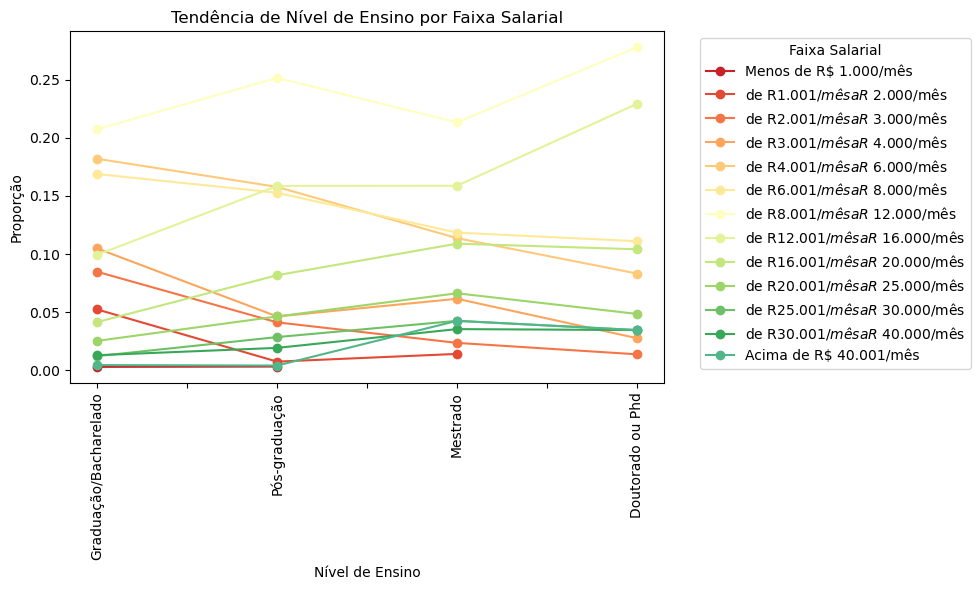

In [14]:
custom_order_xp = [
    "Estudante de Graduação ",
    "Graduação/Bacharelado",
    "Pós-graduação",
    "Mestrado",
    "Doutorado ou Phd"

]

# plt.figure(figsize=(10, 6))
normalized_counts_education = df_essential.groupby('Nivel de Ensino')['Faixa salarial'].value_counts(normalize=True).unstack()
# normalized_counts_education = normalized_counts_education.reindex(custom_order, axis=1)
normalized_counts_education = normalized_counts_education.reindex(custom_order_xp)
normalized_counts_education = normalized_counts_education[custom_order]
normalized_counts_education.plot(kind='line', marker='o', figsize=(10, 6))
plt.xticks(rotation=xtick_rotation)
plt.title('Tendência de Nível de Ensino por Faixa Salarial')
plt.xlabel('Nível de Ensino')
plt.ylabel('Proporção')
plt.legend(title='Faixa Salarial', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<p style="text-align:center; font-size:18px; ">Nota-se que os respondentes com maior nível de ensino ganham mais, reduzindo o mínimo salário encontrado após o mestrado. </p>

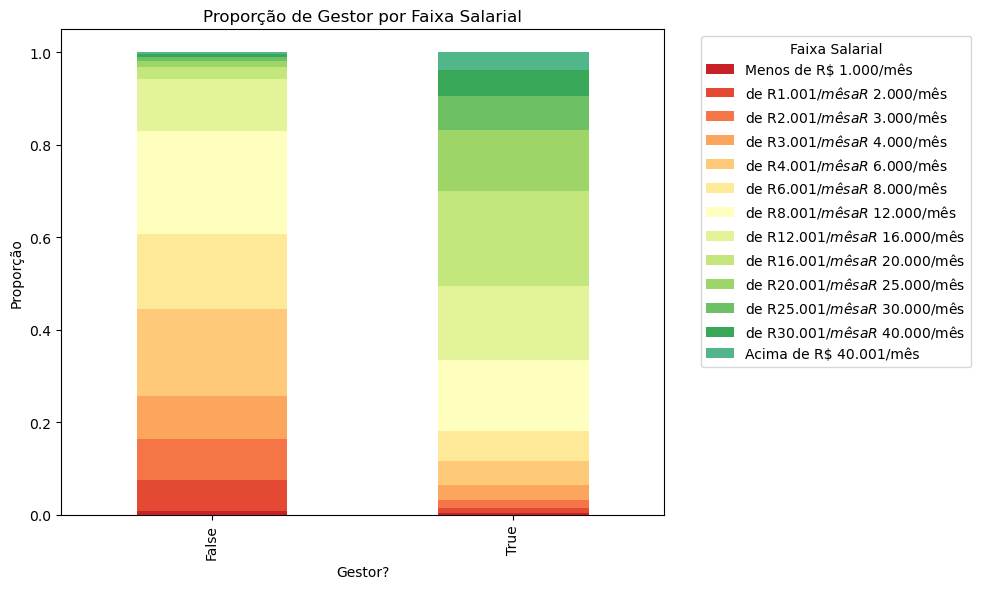

In [15]:
# plt.figure(figsize=(10, 6))
normalized_counts_manager = df_essential.groupby('Gestor?')['Faixa salarial'].value_counts(normalize=True).unstack()
normalized_counts_manager = normalized_counts_manager.reindex(custom_order, axis=1)

normalized_counts_manager.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xticks(rotation=xtick_rotation)
plt.title('Proporção de Gestor por Faixa Salarial')
plt.xlabel('Gestor?')
plt.ylabel('Proporção')
plt.legend(title='Faixa Salarial', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<p style="text-align:center; font-size:18px; ">Os gestores apresentam uma prevalência de salários melhores, o que pode ser visto a partir da quantidade de faixas verdes que indicam um salário maior para os respondentes gestores. </p>

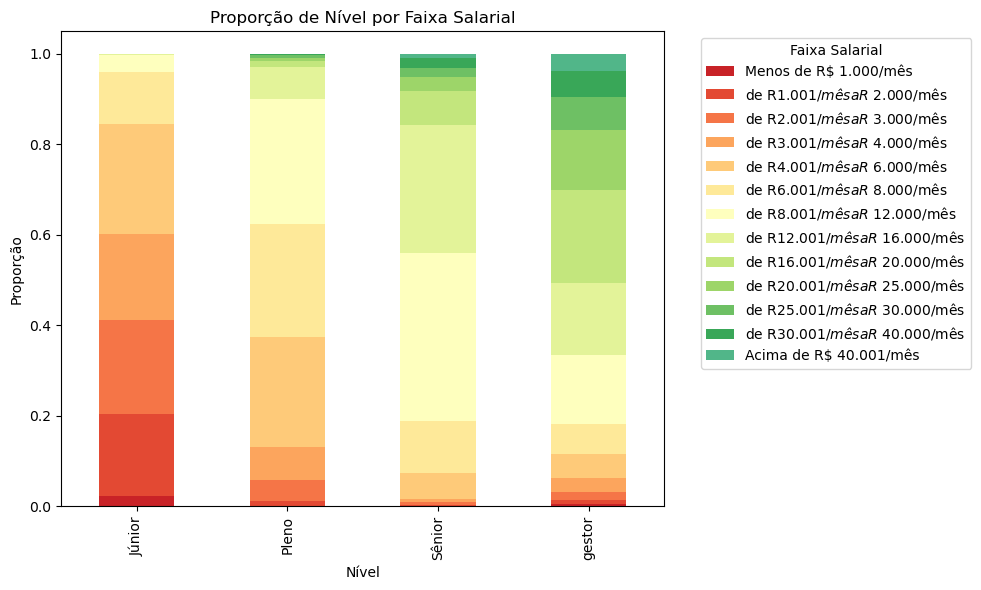

In [16]:
# plt.figure(figsize=(10, 6))
normalized_counts_level = df_essential.groupby('Nivel')['Faixa salarial'].value_counts(normalize=True).unstack()
normalized_counts_level = normalized_counts_level.reindex(custom_order, axis=1)

normalized_counts_level.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xticks(rotation=xtick_rotation)
plt.title('Proporção de Nível por Faixa Salarial')
plt.xlabel('Nível')
plt.ylabel('Proporção')
plt.legend(title='Faixa Salarial', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<p style="text-align:center; font-size:18px; ">Não só comparando os gestores, adicionando também júnior, plenos e sêniors, observa-se que quanto maior o grau a proporção de pessoas com salários baixos diminui. </p>

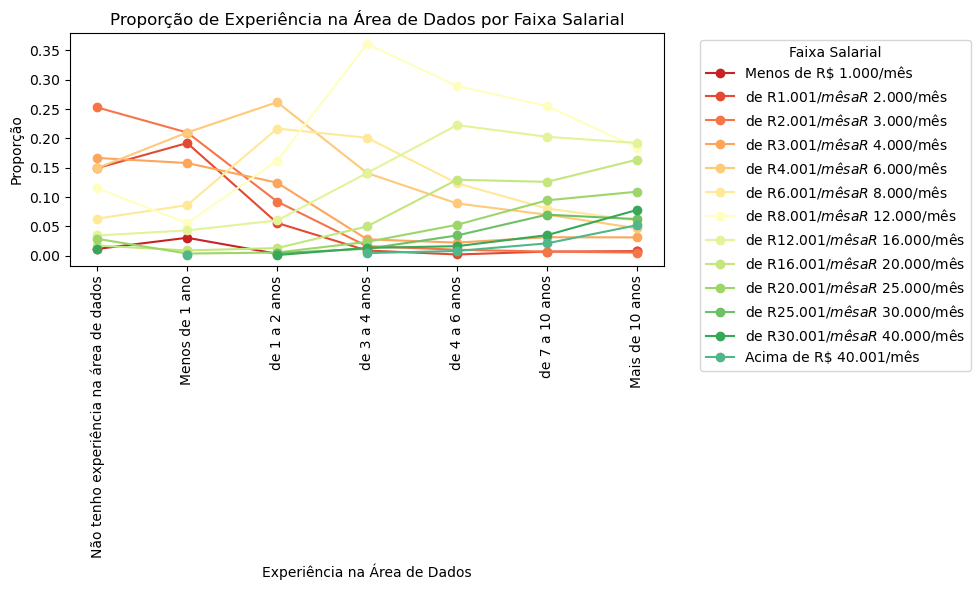

In [17]:
custom_order_age = [
    "Não tenho experiência na área de dados",
    "Menos de 1 ano",
    "de 1 a 2 anos",
    "de 3 a 4 anos",
    "de 4 a 6 anos",
    "de 7 a 10 anos",
    "Mais de 10 anos"

]

# plt.figure(figsize=(10, 6))
normalized_counts_experience = df_essential.groupby('Quanto tempo de experiência na área de dados você tem?')['Faixa salarial'].value_counts(normalize=True).unstack()
# normalized_counts_experience = normalized_counts_experience.reindex(custom_order, axis=1)

normalized_counts_experience = normalized_counts_experience.reindex(custom_order_age)
normalized_counts_experience = normalized_counts_experience[custom_order]

normalized_counts_experience.plot(kind='line', marker='o', figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Proporção de Experiência na Área de Dados por Faixa Salarial')
plt.xlabel('Experiência na Área de Dados')
plt.ylabel('Proporção')
plt.legend(title='Faixa Salarial', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

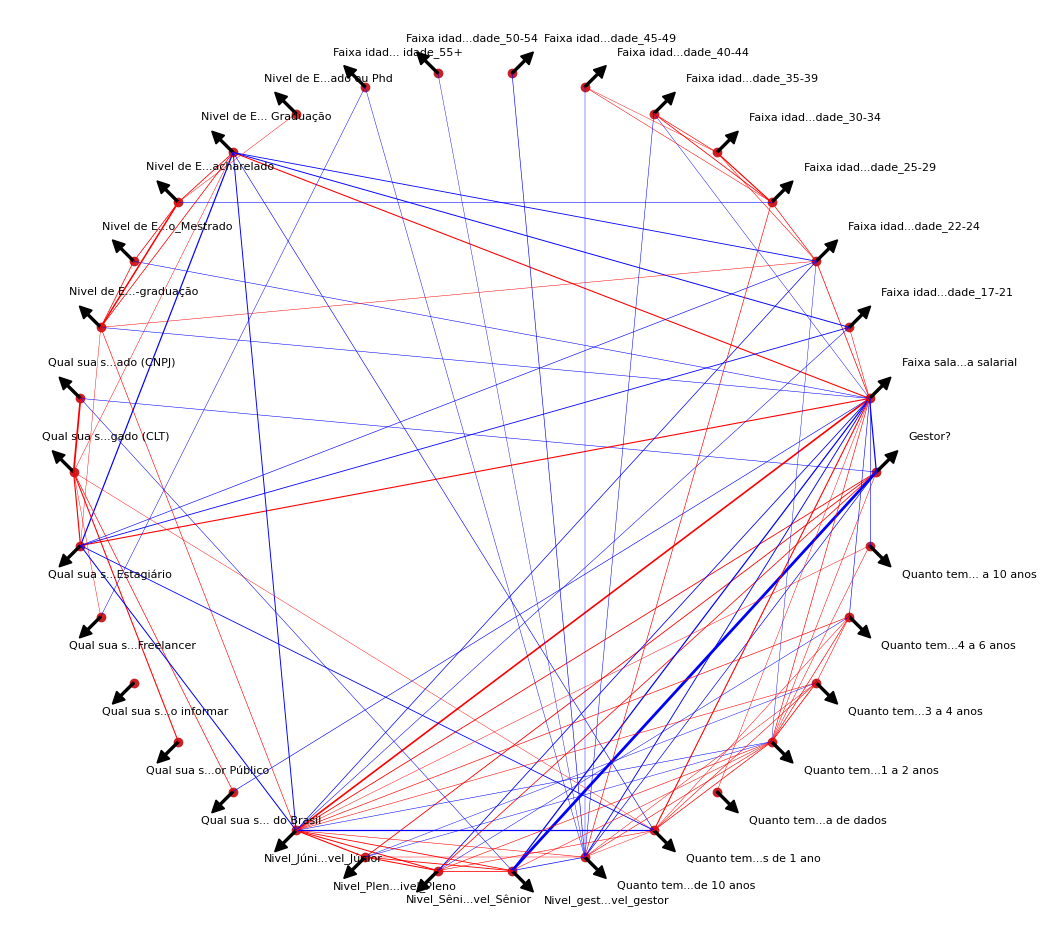

In [18]:
colunas_a_manter = ['Faixa idade','Nivel de Ensino','Qual sua situação atual de trabalho?','Gestor?','Nivel','Quanto tempo de experiência na área de dados você tem?','Faixa salarial']  # Adicione aqui os nomes das colunas que deseja dropar
# Dropar as colunas
df_model = df_essential[colunas_a_manter]

def one_hot_encode(df,cols):
  # checar se são todos uniques
  # for col in cols:
    # display(df[col].unique())
  df = pd.get_dummies(data=df, columns=cols)
  # display(df)
  return df

#convertendo a categoria em categorica
df_model = one_hot_encode(df_model,cols=['Faixa idade','Nivel de Ensino','Qual sua situação atual de trabalho?','Nivel','Quanto tempo de experiência na área de dados você tem?'	])
df_model['Gestor?'] = df_model['Gestor?'].map({True:1,
                                                            False:0
                                                            })
df_model['Faixa salarial'] = df_model['Faixa salarial'].map({'Menos de R$ 1.000/mês':0,
                                                             'de R$ 1.001/mês a R$ 2.000/mês':1,
                                                             'de R$ 2.001/mês a R$ 3.000/mês':2,
                                                             'de R$ 3.001/mês a R$ 4.000/mês':3,
                                                             'de R$ 4.001/mês a R$ 6.000/mês':4,
                                                             'de R$ 6.001/mês a R$ 8.000/mês':5,
                                                             'de R$ 8.001/mês a R$ 12.000/mês':6,
                                                              'de R$ 12.001/mês a R$ 16.000/mês':7,
                                                             'de R$ 16.001/mês a R$ 20.000/mês':8,
                                                              'de R$ 20.001/mês a R$ 25.000/mês':9,
                                                              'de R$ 25.001/mês a R$ 30.000/mês':10,
                                                              'de R$ 30.001/mês a R$ 40.000/mês':11,
                                                             'Acima de R$ 40.001/mês':12
                                                            })
def correlogram(df, limiar,offset = 0.08):
    df_selec_corr = df.corr(method='pearson')
    limiar = limiar
    nr = df_selec_corr.shape[0]
    C = df_selec_corr.to_numpy()
    M = np.zeros((nr, nr))

    for i in range(nr):
        for j in range(nr):
            if abs(C[i, j]) >= abs(limiar) and i != j:
                M[i, j] = 1

    np.set_printoptions(threshold=np.inf)

    n = M.shape[0]
    plt.figure(figsize=(12, 12))
    plt.rcParams.update({'font.size': 8})
    plt.axis('off')
    axis = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x, y = np.cos(axis), np.sin(axis)
    offset = offset  # Adjust the offset value as needed

    for i in range(n):
        for j in range(i + 1, n):
            if M[i, j] == 1:
                correlation = C[i, j]
                line_color = 'b' if correlation >= 0 else 'r'  # Use blue for positive correlation, red for negative correlation
                line_width = abs(correlation) * 2  # Scale line width based on correlation magnitude
                plt.plot((x[i], x[j]), (y[i], y[j]), color=line_color, linewidth=line_width)

    plt.scatter(x, y)

    for i, txt in enumerate(df_selec_corr.columns.values):
        if len(txt) > 10:
            txt = txt[:10] + '...' + txt[-10:]  # Truncate the string if it's longer than 10 characters
        if txt == 'diabetes':
            plt.annotate(txt, (x[i] , y[i]), weight='bold', ha='center', va='center')
        elif y[i] >= 0:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] + offset))  # Add negative offset for left top annotations
                plt.arrow(x[i], y[i] , -0.4*offset, 0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
            else:
                plt.annotate(txt, (x[i] + offset, y[i] + offset))  # Add positive offset for right top annotations
                plt.arrow(x[i] , y[i] , 0.4*offset, 0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
        else:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] - offset))  # Add negative offset for left bottom annotations
                plt.arrow(x[i] , y[i] , -0.4*offset, -0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
            else:
                plt.annotate(txt, (x[i] + offset, y[i] - offset))  # Add positive offset for right bottom annotations
                plt.arrow(x[i], y[i], 0.4*offset, -0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
    plt.show()
    
correlogram(df_model,limiar=0.15)

In [19]:


df_model

,Gestor?,Faixa salarial,Faixa idade_17-21,Faixa idade_22-24,Faixa idade_25-29,Faixa idade_30-34,Faixa idade_35-39,Faixa idade_40-44,Faixa idade_45-49,Faixa idade_50-54,Faixa idade_55+,Nivel de Ensino_Doutorado ou Phd,Nivel de Ensino_Estudante de Graduação,Nivel de Ensino_Graduação/Bacharelado,Nivel de Ensino_Mestrado,Nivel de Ensino_Pós-graduação,Qual sua situação atual de trabalho?_Empreendedor ou Empregado (CNPJ),Qual sua situação atual de trabalho?_Empregado (CLT),Qual sua situação atual de trabalho?_Estagiário,Qual sua situação atual de trabalho?_Freelancer,Qual sua situação atual de trabalho?_Prefiro não informar,Qual sua situação atual de trabalho?_Servidor Público,Qual sua situação atual de trabalho?_Vivo no Brasil e trabalho remoto para empresa de fora do Brasil,Nivel_Júnior,Nivel_Pleno,Nivel_Sênior,Nivel_gestor,Quanto tempo de experiência na área de dados você tem?_Mais de 10 anos,Quanto tempo de experiência na área de dados você tem?_Menos de 1 ano,Quanto tempo de experiência na área de dados você tem?_Não tenho experiência na área de dados,Quanto tempo de experiência na área de dados você tem?_de 1 a 2 anos,Quanto tempo de experiência na área de dados você tem?_de 3 a 4 anos,Quanto tempo de experiência na área de dados você tem?_de 4 a 6 anos,Quanto tempo de experiência na área de dados você tem?_de 7 a 10 anos
0,0,6,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
1,1,4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,7,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,0,7,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4265,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4266,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4267,0,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4268,1,8,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [20]:
X =  df_model.drop('Faixa salarial', axis=1)

y = df_model['Faixa salarial']

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 70% do dataset - 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# test é 15% do dataset inicial - 0.15/0.3 = 50% dos 30% de antes
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True)

In [21]:
rfmodel, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =True,model='tuned')

[I 2023-08-08 02:07:36,861] A new study created in memory with name: no-name-034073d6-0218-4864-a0fb-b0ff5f42d96c


user chose to do gridsearch


[I 2023-08-08 02:07:37,610] Trial 0 finished with value: 0.21061288157544933 and parameters: {'n_estimators': 208, 'max_depth': 29, 'min_samples_split': 28, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.21061288157544933.
[I 2023-08-08 02:07:39,629] Trial 1 finished with value: 0.20443214991394848 and parameters: {'n_estimators': 580, 'max_depth': 31, 'min_samples_split': 82, 'min_samples_leaf': 35}. Best is trial 0 with value: 0.21061288157544933.
[I 2023-08-08 02:07:42,785] Trial 2 finished with value: 0.20603163543532718 and parameters: {'n_estimators': 872, 'max_depth': 49, 'min_samples_split': 113, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.21061288157544933.
[I 2023-08-08 02:07:44,189] Trial 3 finished with value: 0.19853589716778489 and parameters: {'n_estimators': 376, 'max_depth': 47, 'min_samples_split': 47, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.21061288157544933.
[I 2023-08-08 02:07:45,491] Trial 4 finished with value: 0.20813908789960392

creating best model predictions


RandomForestClassifier(max_depth=29, min_samples_leaf=32, min_samples_split=28,
                       n_estimators=208, random_state=43)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 29,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 32,
 'min_samples_split': 28,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 208,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 43,
 'verbose': 0,
 'warm_start': False}

In [22]:
y_valrf, y_val_predrf,macro_f1_scorerf = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 35.55%
Acurácia balanceada na validação: 21.06%
Macro f1 score: 18.30%


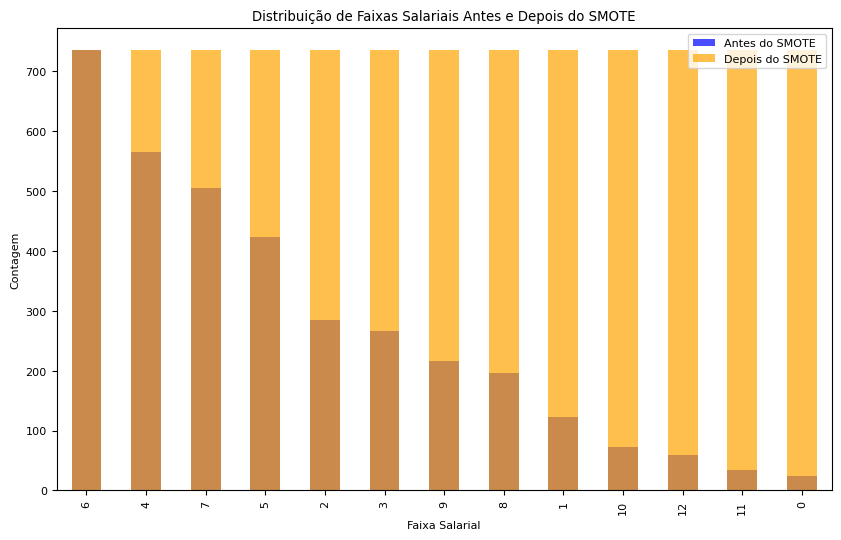

In [23]:
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Contagens antes e depois do SMOTE
count_before = y.value_counts()
count_after = y_resampled.value_counts()

# Plotar o gráfico comparativo com superposição
plt.figure(figsize=(10, 6))
count_before.plot(kind='bar', color='blue', alpha=0.7, label='Antes do SMOTE')
count_after.plot(kind='bar', color='orange', alpha=0.7, label='Depois do SMOTE')
plt.xlabel('Faixa Salarial')
plt.ylabel('Contagem')
plt.title('Distribuição de Faixas Salariais Antes e Depois do SMOTE')
plt.legend()
plt.show()

In [24]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

In [ ]:
rfmodelsmote, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =True,model='tuned')

Acurácia na validação: 40.49%
Acurácia balanceada na validação: 47.32%
              precision    recall  f1-score   support

           0       0.27      0.80      0.40         5
           1       0.56      0.43      0.48        35
           2       0.32      0.31      0.32        39
           3       0.31      0.45      0.37        42
           4       0.45      0.29      0.35        76
           5       0.46      0.47      0.47        76
           6       0.61      0.35      0.44       118
           7       0.34      0.42      0.38        60
           8       0.31      0.50      0.39        32
           9       0.38      0.56      0.45        18
          10       0.29      0.45      0.36        11
          11       0.31      0.62      0.42         8
          12       0.38      0.50      0.43         6

    accuracy                           0.40       526
   macro avg       0.38      0.47      0.40       526
weighted avg       0.44      0.40      0.41       526



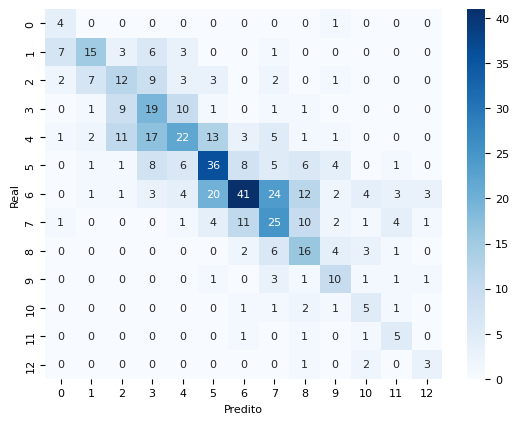

Sensitivity :  1.0
Specificity :  0.6818181818181818


In [26]:
print_classification_report(y_val, y_pred,auc_metrics=False)

In [27]:
y_valrfsmote, y_val_predrfsmote,macro_f1_scorerfsmote = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 40.49%
Acurácia balanceada na validação: 47.32%
Macro f1 score: 40.36%


In [ ]:
xgbmodel, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='xgboost')

In [29]:
y_valxgb, y_val_predxgb,macro_f1_scorexgb = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 52.66%
Acurácia balanceada na validação: 54.81%
Macro f1 score: 55.57%


In [ ]:
model_mlp, X_val,y_pred, y_val,y_pred_proba = train_model_nn(X_train, X_val, y_train, y_val,grid_search =True)

In [31]:
y_valmlp, y_val_predmlp,macro_f1_scoremlp = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 51.71%
Acurácia balanceada na validação: 55.58%
Macro f1 score: 54.89%


<p style="text-align:center; font-size:18px; ">O modelo performou similar ao XGboost para o conjunto de validação, apesar de ser mais complexo, o que indica que o problema pode ser complexo para que padrões não sejam encontrados</p>

> Também foram executados testes com modelos mais complexos como o Tabnet usando pytorch. A documentação pode ser vista [aqui](https://dreamquark-ai.github.io/tabnet/), se tratando da rede TabNet: Attentive Interpretable Tabular Learning. É uma rede interpretável com mecanismos de atenção para dados tabulares. Os resultados não foram incluídos já que não apresentou um ganho valioso nas métricas e tem o tempo de treinamento extenso.

In [32]:
# Função para substituir valores maiores que 8 por 8
def replace_over_8(val):
    return min(val, 8)

# Aplicar a função em todas as colunas que contêm faixas de salários
df_model['Faixa salarial'] = df_model['Faixa salarial'].apply(replace_over_8)


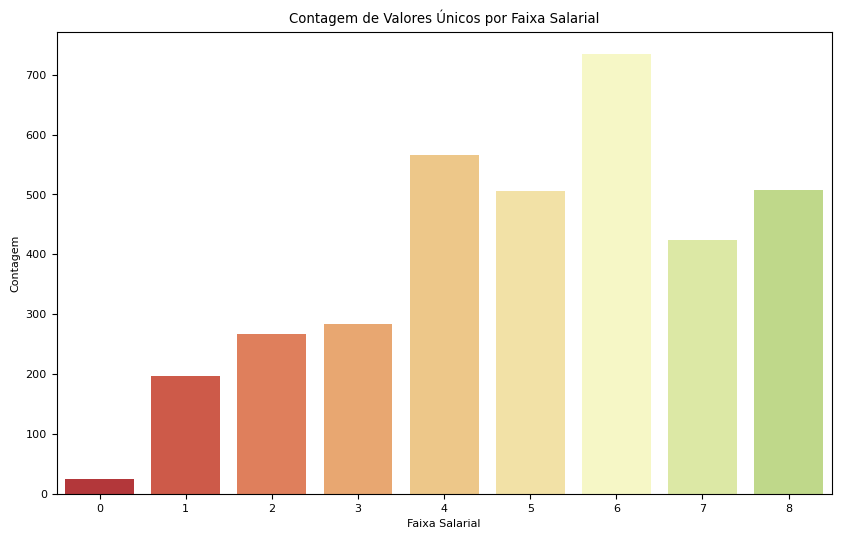

In [33]:


# Contagem de valores únicos na coluna "Faixa salarial"
unique_counts = df_model['Faixa salarial'].value_counts()

# Gráfico com seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_counts.index, y=unique_counts.values)
plt.xlabel('Faixa Salarial')
plt.ylabel('Contagem')
plt.title('Contagem de Valores Únicos por Faixa Salarial')
plt.show()

Notamos que os valores únicos por faixa mostrar que ficou um pouco melhor distribuída a quantidade de respondentes por faixa.

In [34]:
X =  df_model.drop('Faixa salarial', axis=1)

y = df_model['Faixa salarial']

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 70% do dataset - 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# test é 15% do dataset inicial - 0.15/0.3 = 50% dos 30% de antes
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True)

In [ ]:
modelrf_grouped, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =True,model='tuned')

<p style="text-align:center; font-size:18px; ">Com o mesmo modelo de Random Forest, percebe-se uma piora expressiva das métricas</p>

In [36]:
y_valrf_grouped, y_val_predrf_grouped,macro_f1_scorerf_grouped = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 41.44%
Acurácia balanceada na validação: 31.41%
Macro f1 score: 29.68%


In [37]:
smote = SMOTE(random_state=SEED)
# Upsample the minority class using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

In [ ]:
modelrf_groupedsmote, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =True,model='tuned')

<p style="text-align:center; font-size:18px; ">Realizando o SMOTE no novo conjunto, percebe-se que as métricas ainda estão abaixo dos primeiros experimentos.</p>

In [39]:
y_valrf_groupedsmote, y_val_predrf_groupedsmote,macro_f1_scorerf_groupedsmote = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 34.41%
Acurácia balanceada na validação: 35.15%
Macro f1 score: 30.26%


In [ ]:
xgbmodelgrouped, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='xgboost')

<p style="text-align:center; font-size:18px; ">O modelo XGboost segue com uma performance ruim.</p>

In [41]:
# print_classification_report(y_val, y_pred,auc_metrics=False)
y_valxgb_groupedsmote, y_val_predxgb_groupedsmote,macro_f1_scorexgb_groupedsmote = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 31.18%
Acurácia balanceada na validação: 27.08%
Macro f1 score: 26.85%


In [ ]:
model_mlpgrouped, X_val,y_pred, y_val,y_pred_proba = train_model_nn(X_train, X_val, y_train, y_val,grid_search =True)

<p style="text-align:center; font-size:18px; ">O MLP também  segue performando pior para o conjunto de validação.</p>

In [43]:
# print_classification_report(y_val, y_pred,y_pred)
y_valmlp_groupedsmote, y_val_predmlp_groupedsmote,macro_f1_scoremlp_groupedsmote = print_classification_report_refact(y_val, y_pred,auc_metrics=False)

Acurácia na validação: 31.37%
Acurácia balanceada na validação: 29.04%
Macro f1 score: 29.38%


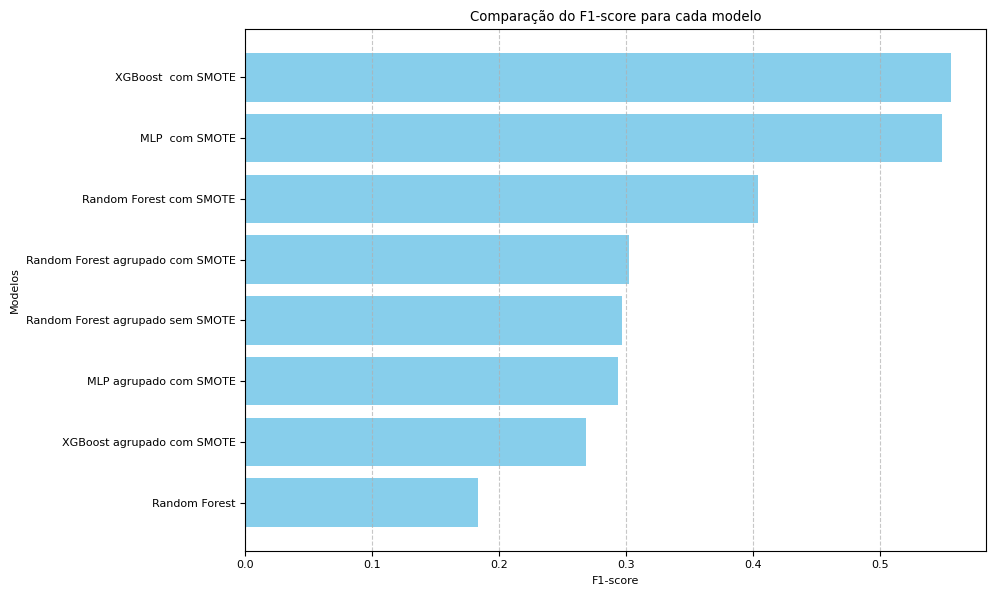

In [44]:
import matplotlib.pyplot as plt

models = [
    'MLP agrupado com SMOTE', 'XGBoost agrupado com SMOTE',
    'Random Forest agrupado com SMOTE', 'Random Forest agrupado sem SMOTE',
    'MLP  com SMOTE', 'XGBoost  com SMOTE', 'Random Forest com SMOTE', 'Random Forest'
]

f1_scores = [
    macro_f1_scoremlp_groupedsmote ,
    macro_f1_scorexgb_groupedsmote, macro_f1_scorerf_groupedsmote,
    macro_f1_scorerf_grouped, macro_f1_scoremlp,
    macro_f1_scorexgb, macro_f1_scorerfsmote, macro_f1_scorerf
]

# Ordenar os modelos e suas respectivas F1-scores
sorted_models, sorted_f1_scores = zip(*sorted(zip(models, f1_scores), key=lambda x: x[1]))

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(sorted_models, sorted_f1_scores, color='skyblue')
plt.xlabel('F1-score')
plt.ylabel('Modelos')
plt.title('Comparação do F1-score para cada modelo')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [53]:
xgbmodel

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=2,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=2,
             param_grid={'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [65]:
def eval_model_test(X_train, X_val, y_train, y_val, grid_search=False,trials=10,view_trees=False,model=xgbmodel):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val

    y_pred = model.predict(X_val)

    try:
      y_pred_proba = model.predict_proba(X_val)[:, 1]
    except:

      y_pred_proba = y_pred
    return model, X_val,y_pred, y_val,y_pred_proba

In [68]:
xgbmodel, X_test,y_pred, y_test,y_pred_proba = eval_model_test(X_train, X_test, y_train, y_test)

<p style="text-align:center; font-size:18px; ">Avaliando no teste como um todo, percebemos que foi possível generalizar e encontrar métricas um pouco menores.</p>

In [69]:
y_valrf_groupedtest, y_val_predrf_groupedtest,macro_f1_scorerf_groupedtest = print_classification_report_refact(y_test, y_pred,auc_metrics=False)

Acurácia na validação: 46.87%
Acurácia balanceada na validação: 48.53%
Macro f1 score: 31.83%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true



In [49]:

custom_data = {
    'Gestor?': False,
    'Faixa idade_17-21': 0,
    'Faixa idade_22-24': 0,
    'Faixa idade_25-29': 1,
    'Faixa idade_30-34': 0,
    'Faixa idade_35-39': 0,
    'Faixa idade_40-44': 0,
    'Faixa idade_45-49': 0,
    'Faixa idade_50-54': 0,
    'Faixa idade_55+': 0,
    'Nivel de Ensino_Doutorado ou Phd': 0,
    'Nivel de Ensino_Estudante de Graduação': 0,
    'Nivel de Ensino_Graduação/Bacharelado': 0,
    'Nivel de Ensino_Mestrado': 0,
    'Nivel de Ensino_Pós-graduação': 1,
    'Qual sua situação atual de trabalho?_Empreendedor ou Empregado (CNPJ)': 0,
    'Qual sua situação atual de trabalho?_Empregado (CLT)': 0,
    'Qual sua situação atual de trabalho?_Estagiário': 0,
    'Qual sua situação atual de trabalho?_Freelancer': 0,
    'Qual sua situação atual de trabalho?_Prefiro não informar': 1,
    'Qual sua situação atual de trabalho?_Servidor Público': 0,
    'Qual sua situação atual de trabalho?_Vivo no Brasil e trabalho remoto para empresa de fora do Brasil': 0,
    'Nivel_Júnior': 0,
    'Nivel_Pleno': 1,
    'Nivel_Sênior': 0,
    'Nivel_gestor': 0,
    'Quanto tempo de experiência na área de dados você tem?_Mais de 10 anos': 0,
    'Quanto tempo de experiência na área de dados você tem?_Menos de 1 ano': 0,
    'Quanto tempo de experiência na área de dados você tem?_Não tenho experiência na área de dados': 0,
    'Quanto tempo de experiência na área de dados você tem?_de 1 a 2 anos': 0,
    'Quanto tempo de experiência na área de dados você tem?_de 3 a 4 anos': 1,
    'Quanto tempo de experiência na área de dados você tem?_de 4 a 6 anos': 0,
    'Quanto tempo de experiência na área de dados você tem?_de 7 a 10 anos': 0
}

In [63]:


# Create a DataFrame with a single row for the custom data
custom_df = pd.DataFrame([custom_data])
display(custom_df)
# Use the model's predict method to get the predictions for the custom data
# predictions = model.predict(custom_df)
predictions = modelrf_grouped.predict(custom_df)

print(predictions)

# Define the mapping dictionary
salary_map = {
    0: 'Menos de R$ 1.000/mês',
    1: 'de R$ 1.001/mês a R$ 2.000/mês',
    2: 'de R$ 2.001/mês a R$ 3.000/mês',
    3: 'de R$ 3.001/mês a R$ 4.000/mês',
    4: 'de R$ 4.001/mês a R$ 6.000/mês',
    5: 'de R$ 6.001/mês a R$ 8.000/mês',
    6: 'de R$ 8.001/mês a R$ 12.000/mês',
    7: 'de R$ 12.001/mês a R$ 16.000/mês',
    8: 'de R$ 16.001/mês a R$ 20.000/mês',
    9: 'de R$ 20.001/mês a R$ 25.000/mês',
    10: 'de R$ 25.001/mês a R$ 30.000/mês',
    11: 'de R$ 30.001/mês a R$ 40.000/mês',
    12: 'Acima de R$ 40.001/mês'
}

# Map the single prediction to its corresponding salary range using the dictionary
predicted_salary = salary_map.get(predictions[0])

print(f'você deve ganhar {predicted_salary}')

,Gestor?,Faixa idade_17-21,Faixa idade_22-24,Faixa idade_25-29,Faixa idade_30-34,Faixa idade_35-39,Faixa idade_40-44,Faixa idade_45-49,Faixa idade_50-54,Faixa idade_55+,Nivel de Ensino_Doutorado ou Phd,Nivel de Ensino_Estudante de Graduação,Nivel de Ensino_Graduação/Bacharelado,Nivel de Ensino_Mestrado,Nivel de Ensino_Pós-graduação,Qual sua situação atual de trabalho?_Empreendedor ou Empregado (CNPJ),Qual sua situação atual de trabalho?_Empregado (CLT),Qual sua situação atual de trabalho?_Estagiário,Qual sua situação atual de trabalho?_Freelancer,Qual sua situação atual de trabalho?_Prefiro não informar,Qual sua situação atual de trabalho?_Servidor Público,Qual sua situação atual de trabalho?_Vivo no Brasil e trabalho remoto para empresa de fora do Brasil,Nivel_Júnior,Nivel_Pleno,Nivel_Sênior,Nivel_gestor,Quanto tempo de experiência na área de dados você tem?_Mais de 10 anos,Quanto tempo de experiência na área de dados você tem?_Menos de 1 ano,Quanto tempo de experiência na área de dados você tem?_Não tenho experiência na área de dados,Quanto tempo de experiência na área de dados você tem?_de 1 a 2 anos,Quanto tempo de experiência na área de dados você tem?_de 3 a 4 anos,Quanto tempo de experiência na área de dados você tem?_de 4 a 6 anos,Quanto tempo de experiência na área de dados você tem?_de 7 a 10 anos
0,False,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0


[6]
você deve ganhar de R$ 8.001/mês a R$ 12.000/mês


In [75]:
best_xgb_model = xgbmodel.best_estimator_

In [76]:
best_xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=2, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

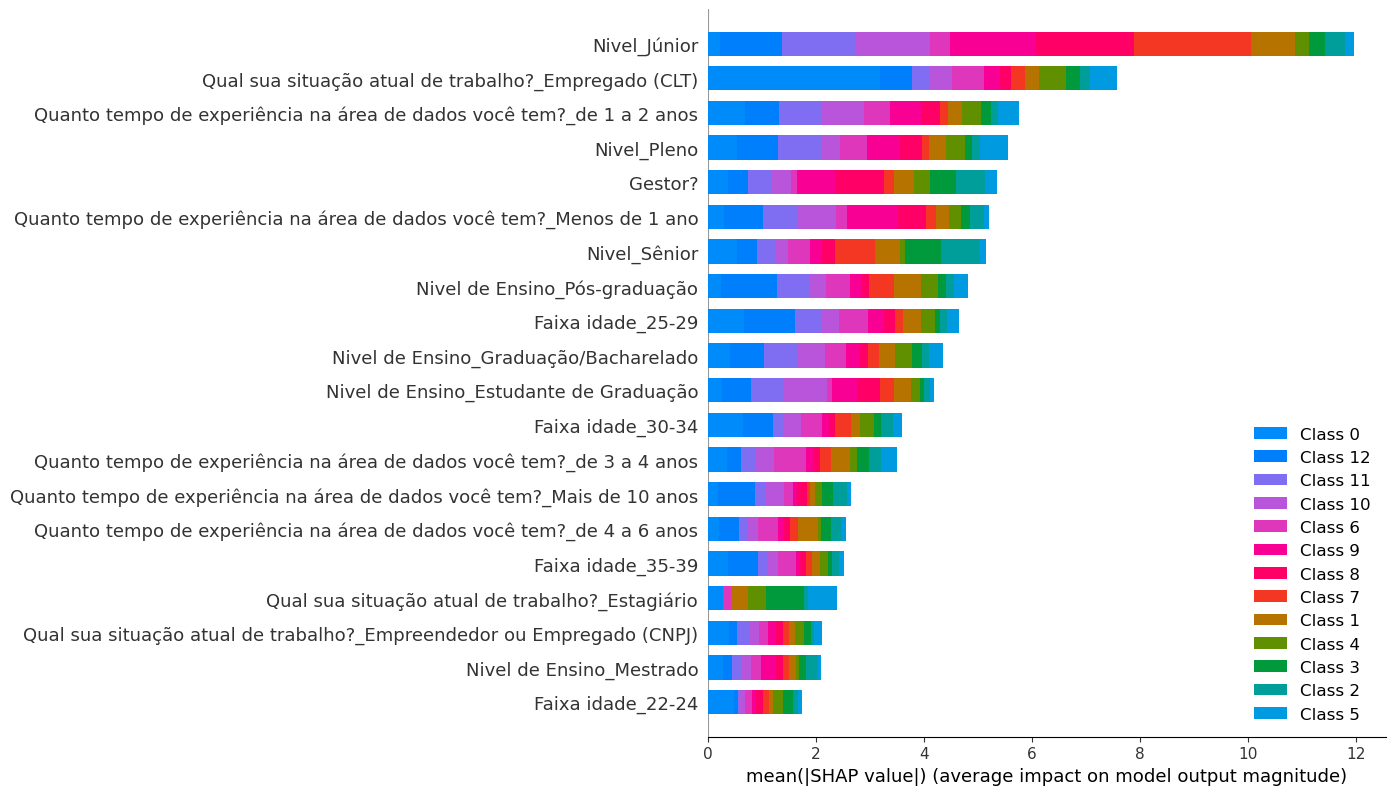

In [77]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(custom_df)

shap.initjs()

shap_values = shap.TreeExplainer(best_xgb_model).shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar",plot_size=(14,8))
# plt.tight_layout()
# plt.figsize(10,6)
# violin não vai AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!


<p style="text-align:center; font-size:18px">Para o modelo como um todo, os níveis de carreira foram muito consideráveis na hora de fornecer as predições. Ser empregado CLT e Gestor também tiveram um impacto considerável, além de possuir pouca experiência na área.  </p>

<p style="text-align:center; font-size:18px">Para a predição individual, a falta do emprego CLT e não informar a situação atual de trabalho foram significativos para uma predição menor de salário. Ter de 3 a 4 anos de experiência na área e ser pleno foi o que mais afetou o modelo para um valor maior. </p>

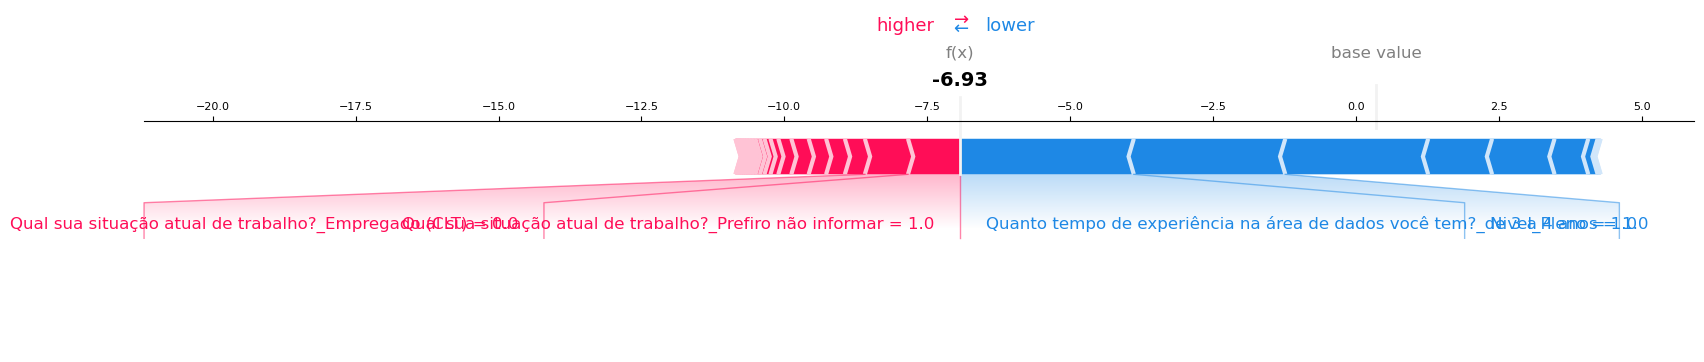

In [78]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(custom_df)
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], custom_df.iloc[0, :], matplotlib = True)

